# Information Retrieval Exercise 1 Notebook

This is the template notebook for Exercise 1. This is an assessed exercise. The detailed specification for the exercise and the corresponding Exercise 1 Quiz submission instance are available on the Moodle page of the course.

## Assumed Knowledge

This Exercise assumes knowedge of Pandas and PyTerrier from the Warmup Exercise, which you should have completed by now. The relevant parts of the PyTerrier documentation are:
 - [Using Terrier indices in PyTerrier](https://pyterrier.readthedocs.io/en/latest/terrier-indexing.html)
 - [Terrier Retrieval using PyTerrier](https://pyterrier.readthedocs.io/en/latest/terrier-retrieval.html), e.g. BatchRetrieve
 - [Operators on PyTerrier transformers](https://pyterrier.readthedocs.io/en/latest/operators.html)


## Setup

NB: Windows users may need to use `%pip install  --user python-terrier gensim` -- you can ignore warnings about cython, PATH etc. If in doubt, resort to Colab.

In [ ]:
%pip install -q python-terrier gensim


In [ ]:
import pyterrier as pt
if not pt.started():
  pt.init()

import pandas as pd
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_rows', 200)

# Datasets for Ex1

For Exercise 1, we'll be using the Datasets API to obtain the files we need for this exercise. PyTerrier actually provides many datasets. You can list all of them using `pt.list_datasets()`.

In [ ]:
pt.list_datasets()

,dataset,topics,topics_lang,qrels,corpus,corpus_lang,index,info_url
0,50pct,"[training, validation]",en,"[training, validation]",None,None,"[ex2, ex3]",None
1,antique,"[train, test]",en,"[train, test]",True,en,None,https://ciir.cs.umass.edu/downloads/Antique/readme.txt
2,vaswani,True,en,True,True,en,True,http://ir.dcs.gla.ac.uk/resources/test_collections/npl/
3,msmarco_document,"[train, dev, test, test-2020, leaderboard-2020]",en,"[train, dev, test, test-2020]",True,en,True,https://microsoft.github.io/msmarco/
4,msmarcov2_document,"[train, dev1, dev2, valid1, valid2, trec_2021]",en,"[train, dev1, dev2, valid1, valid2]",None,None,True,https://microsoft.github.io/msmarco/TREC-Deep-Learning.html
...,...,...,...,...,...,...,...,...
641,irds:hc4,None,None,None,None,None,None,https://ir-datasets.com/hc4.html
654,irds:neuclir,None,None,None,None,None,None,https://ir-datasets.com/neuclir.html
655,irds:neuclir/1,None,None,None,None,None,None,https://ir-datasets.com/neuclir.html#neuclir/1
662,trec-deep-learning-docs,"[train, dev, test, test-2020, leaderboard-2020]",en,"[train, dev, test, test-2020]",True,en,True,https://microsoft.github.io/msmarco/


There are several sets of files we need for Exercise 1:
 - We need an index for 50% of the TREC GOV corpus. We provide this through the "50pct" dataset, but you will need the username and password that we will assign to you once you sign the user license agreement.
 - the topics (queries) and qrels (relevance assessments) for evaluating the performance of our search engine. These come from the "trec-wt-2004" dataset.

Update your username and password. DO NOT SHARE your login details with other students - all they need to do is to agree to the user agreement on Moodle.



In [ ]:
USERNAME = "2850756t"
PASSWORD = "799cb19a"

dotgov_50pct = pt.get_dataset("50pct", user=USERNAME, password=PASSWORD)
dotgov_topicsqrels = pt.get_dataset("trec-wt-2004")

The size of the "50pct" index is 800MB - this will take a minute or so for Colab to download before we load it for the first time.

In [ ]:
indexref = dotgov_50pct.get_index('ex2')
index = pt.IndexFactory.of(indexref)


# Q1

Using this setup, you now have sufficient knowledge from the warm-up exercise to complete this task, namely to get the indexing statistics of the "50pct" collection.

In [ ]:
# Start by using PyTerrier to load the provided index of the collection. Print the index collection
# statistics and answer the corresponding Quiz questions by entering the obtained indexing statistics:
# number of documents, number of terms, number of tokens, number of postings.

print(index.getCollectionStatistics())

# Number of docs: 807775
# Number of terms: 2043788
# Number of postings: 177737957
# Number of tokens: 572916194


Number of documents: 807775
Number of terms: 2043788
Number of postings: 177737957
Number of fields: 0
Number of tokens: 572916194
Field names: []
Positions:   false



# Retrieval & Evaluation

In our experiments, we are using three sets of topics: "hp", "np" and "td". We can obtain them from the `dotgov_topicsqrels` dataset as follows:

In [ ]:
topics = dotgov_topicsqrels.get_topics(variant="hp")
topics.head(5)

,qid,query
0,6,philadelphia streets
1,7,togo embassy
2,9,baltimore
3,17,secure linux
4,29,grand canyon monitoring and research center


Let's create a simple TF_IDF retriever - we will use this for demonstrating IR evaluation using PyTerrier.

In [ ]:
retr = pt.BatchRetrieve(index, wmodel="TF_IDF")

Let's see how we can actually evaluate our TF_IDF retrieval system. Firstly, we'll need the qrels.

In [ ]:
qrels = dotgov_topicsqrels.get_qrels(variant='hp')

We can use `pt.Utils.evaluate(results, qrels)` to evaluate the results.    
Args:    
 - metrics, `default = ["map", ndcg"]`, select the evaluation metrics    
 - perquery, `default = False`, select whether to show the mean of the metrics over all queries or the metrics for each query

In [ ]:
res = retr.transform(topics)
eval = pt.Utils.evaluate(res, qrels, metrics=["map"]) # perquery defaults to false here so it shows the results over all queries
eval

{'map': 0.20894845478512017}

However, creating the res dataframe for each system in turn, and then evaluating it, is laborious. We strongly recommend using [`pt.Experiment()`](https://pyterrier.readthedocs.io/en/latest/experiments.html) to evaluate one or more retrieval systems at once, in a declarative manner.

Take the time to read the [documentation for `pt.Experiment()`](https://pyterrier.readthedocs.io/en/latest/experiments.html) to understand its available functionality. Tasks Q2-Q4 will all require that you adapt the arguments to `pt.Experiment()` and use its output in different ways (e.g. for significance testing).

In [ ]:
pt.Experiment(
    [retr],
     dotgov_topicsqrels.get_topics(variant='hp'),
     dotgov_topicsqrels.get_qrels(variant='hp'),
     eval_metrics=['map']
)

,name,map
0,BR(TF_IDF),0.208948


# Q2(a)

You now have enough information to complete Q2(a) of the assessed exercise.

*Hint*: We encourage you to write your own functions that perform reusable operations across different topic sets.

In [ ]:
# rename retr to retr_tfidf for specs
retr_tfidf = retr
# retrieve bm25
retr_bm25 = pt.BatchRetrieve(index, wmodel="BM25")
# retrieve pl2
retr_pl2 = pt.BatchRetrieve(index, wmodel="PL2")

# Define a function for (a)
def run_experiment_q2(topic_set):
  # this experiment takes the specific topic set
  # uses the evaluation metric MAP
  # rounds MAP to 4 decimals
  # and uses TFIDF as a baseline
  return pt.Experiment(
      [retr_tfidf, retr_bm25, retr_pl2],
      pt.get_dataset("trec-wt-2004").get_topics(topic_set),
      pt.get_dataset("trec-wt-2004").get_qrels(topic_set),
      eval_metrics=['map'],
      round={"map" : 4},
      names=["TFIDF", "BM25", "PL2"],
      baseline=0
  )

Now I will run the experiment on the 'hp' set.

In [ ]:
run_experiment_q2('hp')

,name,map,map +,map -,map p-value
0,TFIDF,0.2089,NaN,NaN,NaN
1,BM25,0.2186,11.0,20.0,0.463462
2,PL2,0.2251,17.0,36.0,0.448418


Next I will run the experiment on the 'np' set.

In [ ]:
run_experiment_q2('np')

,name,map,map +,map -,map p-value
0,TFIDF,0.4477,NaN,NaN,NaN
1,BM25,0.4416,6.0,11.0,0.066561
2,PL2,0.4392,17.0,20.0,0.654736


Finally I will run the experiment on the 'td' set.

In [ ]:
run_experiment_q2('td')

,name,map,map +,map -,map p-value
0,TFIDF,0.0698,NaN,NaN,NaN
1,BM25,0.0703,26.0,31.0,0.249291
2,PL2,0.0695,39.0,36.0,0.862098


Let's create dataframes for topics and qrels that include hp, np, and td.

In [ ]:
# create dataframes for each variant's topics
hp_topics = pt.get_dataset("trec-wt-2004").get_topics('hp')
np_topics = pt.get_dataset("trec-wt-2004").get_topics('np')
td_topics = pt.get_dataset("trec-wt-2004").get_topics('td')

# create dataframes for each variant's qrels
hp_qrels = pt.get_dataset("trec-wt-2004").get_qrels('hp')
np_qrels = pt.get_dataset("trec-wt-2004").get_qrels('np')
td_qrels = pt.get_dataset("trec-wt-2004").get_qrels('td')

# concatenate so that all topic sets are in dataframes together
all_topics = pd.concat([hp_topics, np_topics, td_topics])
all_qrels = pd.concat([hp_qrels, np_qrels, td_qrels])



Now we can run the experiment on all three topics combined to retrieve the average MAP across the three topic sets.

In [ ]:
# run the same MAP experiment, this time across all 3 topic sets
pt.Experiment(
      [retr_tfidf, retr_bm25, retr_pl2],
      all_topics,
      all_qrels,
      eval_metrics=['map'],
      round={"map" : 4},
      names=["TFIDF", "BM25", "PL2"],
      baseline=0
  )

,name,map,map +,map -,map p-value
0,TFIDF,0.2422,NaN,NaN,NaN
1,BM25,0.2435,43.0,62.0,0.770693
2,PL2,0.2446,73.0,92.0,0.796196


#Q2(b)

Question 2(b) is concerned with drawing interpolated recall precision graphs, each comparing TFIDF, BM25 and PL2, allowing you to answer the corresponding quiz questions. You will need to use the `"iprec_at_recall"` measure. In each graph, you should have three curves, respectively, addressing the "hp", "np", and "td" topic sets.

*Hint*: Matplotlib has a [`savefig()`](https://chartio.com/resources/tutorials/how-to-save-a-plot-to-a-file-using-matplotlib/#the-savefig-method) function for saving a PNG of a figure.

Function to retrieve iprec_at_recall dataframes for each topic set.

In [ ]:
# this function will retrieve the iprec at recall values for the given topic set
def get_iprec_at_recall(topic_set):
    return pt.Experiment(
        [retr_tfidf, retr_bm25, retr_pl2],
        pt.get_dataset("trec-wt-2004").get_topics(topic_set),
        pt.get_dataset("trec-wt-2004").get_qrels(topic_set),
        eval_metrics=['iprec_at_recall'],
        names=["TFIDF", "BM25", "PL2"]
    )

# call the iprec_at_recall function on each topic set, saving the resulting dataframe
hp_iprec_recall = get_iprec_at_recall('hp')
np_iprec_recall = get_iprec_at_recall('np')
td_iprec_recall = get_iprec_at_recall('td')


Create the HP graph.

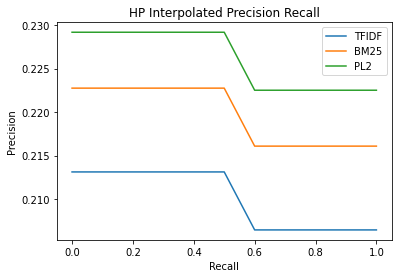

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# create x-axis list incremented by 0.1
x = np.arange(0.0, 1.1, 0.1).tolist()
# save the values for each of the three weighting models
hp_tfidf = hp_iprec_recall.loc[0, :].values.tolist()[1:]
hp_bm25 = hp_iprec_recall.loc[1, :].values.tolist()[1:]
hp_pl2 = hp_iprec_recall.loc[2, :].values.tolist()[1:]

# create the plot
plt.plot(x, hp_tfidf, label = "TFIDF")
plt.plot(x, hp_bm25, label = "BM25")
plt.plot(x, hp_pl2, label = "PL2")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("HP Interpolated Precision Recall")
plt.legend()
plt.savefig("hp_ipr.png")

Here is the full iprec_recall dataframe for 'hp':


In [ ]:
hp_iprec_recall

,name,IPrec@0.0,IPrec@0.1,IPrec@0.2,IPrec@0.3,IPrec@0.4,IPrec@0.5,IPrec@0.6,IPrec@0.7,IPrec@0.8,IPrec@0.9,IPrec@1.0
0,TFIDF,0.213123,0.213123,0.213123,0.213123,0.213123,0.213123,0.206457,0.206457,0.206457,0.206457,0.206457
1,BM25,0.222756,0.222756,0.222756,0.222756,0.222756,0.222756,0.216090,0.216090,0.216090,0.216090,0.216090
2,PL2,0.229183,0.229183,0.229183,0.229183,0.229183,0.229183,0.222516,0.222516,0.222516,0.222516,0.222516


Create the NP Graph.


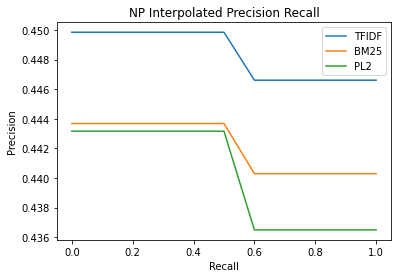

In [ ]:
# save the values for each of the 3 weighting models
np_tfidf = np_iprec_recall.loc[0, :].values.tolist()[1:]
np_bm25 = np_iprec_recall.loc[1, :].values.tolist()[1:]
np_pl2 = np_iprec_recall.loc[2, :].values.tolist()[1:]

# create the tfidf plot
plt.plot(x, np_tfidf, label = "TFIDF")
plt.plot(x, np_bm25, label = "BM25")
plt.plot(x, np_pl2, label = "PL2")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("NP Interpolated Precision Recall")
plt.legend()
plt.savefig("np_ipr.png")

Here is the full iprec_recall dataframe for 'np':

In [ ]:
np_iprec_recall

,name,IPrec@0.0,IPrec@0.1,IPrec@0.2,IPrec@0.3,IPrec@0.4,IPrec@0.5,IPrec@0.6,IPrec@0.7,IPrec@0.8,IPrec@0.9,IPrec@1.0
0,TFIDF,0.449847,0.449847,0.449847,0.449847,0.449847,0.449847,0.446609,0.446609,0.446609,0.446609,0.446609
1,BM25,0.443682,0.443682,0.443682,0.443682,0.443682,0.443682,0.440296,0.440296,0.440296,0.440296,0.440296
2,PL2,0.443162,0.443162,0.443162,0.443162,0.443162,0.443162,0.436496,0.436496,0.436496,0.436496,0.436496


And finally, the TD graph.

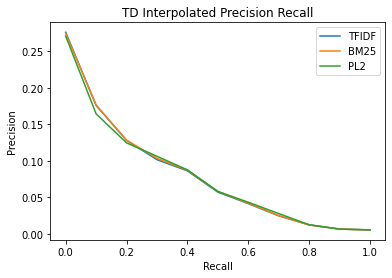

In [ ]:
# save the values for each of the 3 weighting models
td_tfidf = td_iprec_recall.loc[0, :].values.tolist()[1:]
td_bm25 = td_iprec_recall.loc[1, :].values.tolist()[1:]
td_pl2 = td_iprec_recall.loc[2, :].values.tolist()[1:]

# create the plot
plt.plot(x, td_tfidf, label = "TFIDF")
plt.plot(x, td_bm25, label = "BM25")
plt.plot(x, td_pl2, label = "PL2")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("TD Interpolated Precision Recall")
plt.legend()
plt.savefig("td_ipr.png")

Here is the full iprec_recall dataframe for 'td':

In [ ]:
td_iprec_recall

,name,IPrec@0.0,IPrec@0.1,IPrec@0.2,IPrec@0.3,IPrec@0.4,IPrec@0.5,IPrec@0.6,IPrec@0.7,IPrec@0.8,IPrec@0.9,IPrec@1.0
0,TFIDF,0.276114,0.175919,0.128181,0.101728,0.086377,0.057259,0.041509,0.024809,0.012481,0.006777,0.005552
1,BM25,0.274648,0.176544,0.128443,0.103514,0.087262,0.058282,0.042106,0.025099,0.012327,0.006695,0.005591
2,PL2,0.270838,0.164414,0.124698,0.106343,0.087748,0.058264,0.043410,0.027931,0.012583,0.006585,0.005594


#Q2 (c)

Now identify the most effective weighting model in terms of average MAP across the 3 topic sets. To find this model,
simply identify the weighting model with the highest average performance across the 3 topic sets.

In [ ]:
# same experiment from the last question in Q2 (a)
pt.Experiment(
      [retr_tfidf, retr_bm25, retr_pl2],
      all_topics,
      all_qrels,
      eval_metrics=['map'],
      round={"map" : 4},
      names=["TFIDF", "BM25", "PL2"],
      baseline=0
  )

# The max is PL2 with .2446

,name,map,map +,map -,map p-value
0,TFIDF,0.2422,NaN,NaN,NaN
1,BM25,0.2435,43.0,62.0,0.770693
2,PL2,0.2446,73.0,92.0,0.796196


# Q3 Query Expansion

Query expansion is one of the most well-known and effective techniques for improving the effectiveness of a search engine. We'll be using Terrier's Bo1 query expansion model.

See the [relevant documentation](https://pyterrier.readthedocs.io/en/latest/rewrite.html#bo1queryexpansion) about creating a QE transformer pipeline in PyTerrier using the Bo1 model.

You now have enough information to conduct Q3(a) and (b).



#Q3(a)
Run the required experiments for evaluating the application of query expansion on the best weighting model identified in the previous question Q2(c).

Create Bo1 expansion model and pipeline.

In [ ]:
# define the query expansion model
bo1 = pt.rewrite.Bo1QueryExpansion(index)
# retrieve pl2
pl2 = pt.BatchRetrieve(index, wmodel='PL2')
# define expansion pipeline
query_exp_pipeline = pl2 >> bo1 >> pl2

Define experiment with Bo1 QE pipeline.

In [ ]:
# experiment to be run on each set
def run_experiment_q3(topic_set):
  return pt.Experiment(
      # note the experiment is now done on the pipeline
      [query_exp_pipeline],
      pt.get_dataset("trec-wt-2004").get_topics(topic_set),
      pt.get_dataset("trec-wt-2004").get_qrels(topic_set),
      eval_metrics=['map'],
      round={"map" : 4},
      names=["PL2 + QE"]
  )

Run the experiment on the 'hp' set.

In [ ]:
run_experiment_q3('hp')

,name,map
0,PL2 + QE,0.2423


Run the experiment on the 'np' set.

In [ ]:
run_experiment_q3('np')

,name,map
0,PL2 + QE,0.4442


Run the experiment on the 'td' set.

In [ ]:
run_experiment_q3('td')

,name,map
0,PL2 + QE,0.0671


#Q3(b)

This question calls for a query-delta bar chart (See example in Lecture 5). You will need to use the ` perquery=True` option for `pt.Experiment()`.

*Hints*:
 - You may need a [self-join](https://www.w3schools.com/sql/sql_join_self.asp) on a dataframe.
 - You can iterate through a dataframe using [`dataframe.iterrows()`](https://cmdlinetips.com/2018/12/how-to-loop-through-pandas-rows-or-how-to-iterate-over-pandas-rows/)

Here we run the two experiments, first with PL2 alone, then PL2 + QE.

In [ ]:
# import extra measures so we can use AP
from pyterrier.measures import *

# run the experiment using Pl2 without query expansion
td_pl2 = pt.Experiment(
    [pl2],
    pt.get_dataset("trec-wt-2004").get_topics('td'),
    pt.get_dataset("trec-wt-2004").get_qrels('td'),
    # using AP not map
    eval_metrics=[AP],
    names=["PL2"],
    perquery=True
)

# run the experiment using Pl2 with query expansion
td_pl2_qe = pt.Experiment(
    [query_exp_pipeline],
    pt.get_dataset("trec-wt-2004").get_topics('td'),
    pt.get_dataset("trec-wt-2004").get_qrels('td'),
    # using AP not map
    eval_metrics=[AP],
    names=["PL2"],
    perquery=True
)

Let's rename the value columns so that they merge into separate columns.

In [ ]:
# rename columns
td_pl2 = td_pl2.rename(columns={"value": "pl2_val"})
td_pl2_qe = td_pl2_qe.rename(columns={"value": "pl2_qe_val"})

Let's join the two dataframes. We will also add a column for delta_ap.

In [ ]:
# perform join
td_both = pd.merge(td_pl2, td_pl2_qe)
td_both['delta_ap'] = td_both['pl2_qe_val'] - td_both['pl2_val']

Let's create a subset dataframe for the figure, this will only include rows where abs(delta_ap) > 2%.

In [ ]:
# copy the td_both dataframe for the figure
td_both_for_fig = td_both.copy()
td_both_for_fig = td_both_for_fig.sort_values(by=['delta_ap'], ascending=False)

# iterate thru dataframe
for ind, row in td_both_for_fig.iterrows():
  # if the delat_ap value for a row is less than 2% absolute, drop that row
  if abs(row['delta_ap']) < 0.02:
    td_both_for_fig.drop(ind, axis=0, inplace=True)

# reset the index afterwards
td_both_for_fig.reset_index(drop=True, inplace=True)

Now let's make the bar chart.

In [ ]:
# y axis is the delta_ap values
y_axis = td_both_for_fig['delta_ap'].tolist()
# x axis will hold the qids and original queries
x_axis = []

# define dataframe that is the topics dataset
df = pt.get_dataset("trec-wt-2004").get_topics('td')
# iterate through our high absolute delta ap dataframe
for ind, row in td_both_for_fig.iterrows():
  # query and id concatenated into one string and appended to x axis list
  query = str(row['qid']) + ": " + df.loc[df['qid'] == row['qid'], 'query'].iloc[0]
  x_axis.append(query)

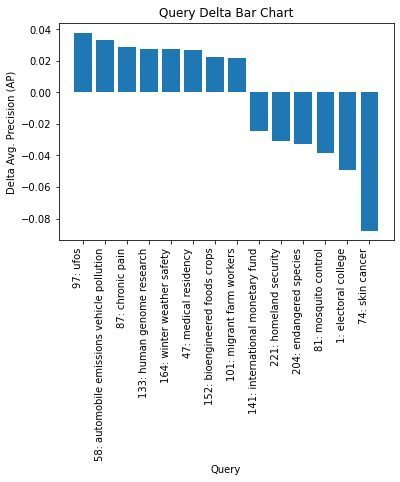

In [ ]:
# create bar chart using matplotlib
plt.bar(x_axis, y_axis)
plt.title('Query Delta Bar Chart')
plt.xlabel('Query')
# rotate the x axis ticks
plt.xticks(rotation=90, ha='right')
plt.ylabel('Delta Avg. Precision (AP)')
# bbox_inches = 'tight' makes it so that the entire image saves
# without this parameter, the image was cutting off the bottom of the x axis ticks
plt.savefig('QueryDeltaBarChart.png', bbox_inches='tight')
plt.show()

Taking a look at reformulated queries for best affected qid 97 ("ufos") and worst affected qid 74 ("skin cancer").

In [ ]:
# save expanded queries
expanded_queries = query_exp_pipeline(pt.get_dataset("trec-wt-2004").get_topics('td'))

In [ ]:
# inspect the reformulated query for ufos
for ind, row in expanded_queries.iterrows():
  if row['qid'] == '97':
    print(row['query'])
    break

applypipeline:off ufo^1.782897603 unidentifi^0.293526425 roswel^0.180836979 extraterrestri^0.155083480 forc^0.149192371 fly^0.144446932 blue^0.138189354 book^0.121246517 air^0.115234556 sight^0.114460152


In [ ]:
# inspect the reformulated query for skin cancer
for ind, row in expanded_queries.iterrows():
  if row['qid'] == '74':
    print(row['query'])
    break

applypipeline:off skin^1.402936462 cancer^1.233351080 sunscreen^0.081970932 cell^0.071433646 melanoma^0.070226770 sun^0.068207895 squamou^0.067213993 carcinoma^0.063889040 uv^0.055406079 basal^0.054696254


# Q4 Word Embeddings

Q4 asks for a word2vec-based query expansion model. Word2vec (also called word embeddings) is a shallow neural network where semantically similar words end up with similar embedding vectors.

If you haven't taken Text-as-Data, you can do some background reading about word embeddings at:
 - https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa
 - https://en.wikipedia.org/wiki/Word2vec
 - https://en.wikipedia.org/wiki/Word_embedding

In general, while word2vec is still a very widely used model, note that it has been surpassed by more complex models such as BERT. But word2vec is still useful to consider in the context of query expansion.


In this part of the exercise, we will use [Gensim](https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html), a Python toolkit for working with a word2vec model.

We are providing a pre-trained word2vec model that Gensim will download and open - the file is very large, so this might take a few minutes to download and a couple of minutes to load. You can read on while it opens.

In [ ]:
import gensim.downloader as api
%time model = api.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded
CPU times: user 2min 54s, sys: 9.43 s, total: 3min 3s
Wall time: 3min 19s


`model` is of type [gensim.models.keyedvectors.KeyedVectors](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors).

You can think of this as a dictionary mapping string words to the vector embeddings for each word.  For example, we can get the vector for the word `'government'` as follows:

In [ ]:
emb = model.get_vector("government")
print(emb.shape)
print(emb)

(300,)
[ 2.5470e-02 -1.0216e-01 -2.8455e-01  2.8603e-01  1.9018e-01 -4.7529e-01
  1.4468e-01  1.9805e-01 -4.2931e-02 -2.9325e+00 -6.3137e-01  9.7630e-02
  1.0803e-01  5.4072e-01 -1.1834e-02  6.8399e-01  3.7241e-02 -3.8651e-01
  5.1331e-01 -4.0682e-01  3.3802e-01  3.9780e-02  1.0934e+00 -2.6993e-02
 -3.2652e-01  1.8426e-01  2.5084e-02 -1.9201e-02 -1.9761e-01  4.9951e-01
 -2.3426e-01 -1.1926e-01  4.3991e-02  3.2443e-01 -2.6306e-01 -1.7991e-01
  2.3484e-01  3.4124e-01 -3.1304e-01 -1.9777e-01 -1.9651e-01  2.8835e-01
 -1.6815e-01  3.8187e-01 -1.6562e-01 -4.0849e-01 -3.9998e-01  2.6185e-01
 -5.3972e-01  2.4353e-01  1.3366e-01 -3.0213e-01  3.7712e-01  1.8414e-01
  7.4082e-03  1.4511e-01  3.2574e-01  1.6853e-01 -1.0872e-01  1.9417e-02
 -3.2784e-01  3.9864e-01 -7.8588e-01  2.3249e-01  2.8092e-02 -4.3737e-01
  1.3954e-01 -4.0254e-01 -3.2712e-01  4.1180e-01  1.3976e-01  6.8819e-01
  3.9624e-02  2.7002e-02  2.3729e-01 -6.6964e-02  5.5686e-02  2.4415e-01
  1.2575e-03  5.1176e-01  1.3287e-01 -3.3563

As you can see, each word is represented by a 300-dimension vector.

We can also ask `model` for the most similar words to `'government'` using [`model.most_similar()`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar). It returns the 10 most similar words, based on the cosine similarity of their emebddings to that of `'government'`.

See also: [Example in Gensim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#what-can-i-do-with-word-vectors).

In [ ]:
model.most_similar("government")

[('governments', 0.6940836906433105),
 ('administration', 0.6544793844223022),
 ('authorities', 0.6283242702484131),
 ('officials', 0.6262894868850708),
 ('federal', 0.6101000905036926),
 ('opposition', 0.6081914901733398),
 ('official', 0.5788125395774841),
 ('saying', 0.5778090953826904),
 ('public', 0.575609564781189),
 ('ministry', 0.5619341135025024)]

As you can see, some words are clearly related to the original word `'government'`, including some lexical variations (`'governments'`), as well as semantically similar (`"authorities"`) words. You can also see some words that perhaps seem unrelated - probably they are highly weighted because they appeared in similar contexts to `"government"` (e.g. `"saying"`).

#Q4 Word2Vec-based Query Expansion

The next task is to use `model` to develop your custom transformer for a word2vec-based query expansion, and use it with PL2.

*Hints about the customer transformer*:
 - Inspired by Pandas, PyTerrier has the notion of [apply functions](https://pyterrier.readthedocs.io/en/latest/apply.html) for applying transformations.
 - What to do with out-of-vocabulary (OOV) words?
 - How many similar terms to identify for each existing query term?
 - How to ensure fair comparison with the experiments conducted in Q3.
 - What is the relative importance of these new terms compared to the existing query terms? e.g. you might want to give more emphasis to the original query terms (See Lecture 6).
 - How/if to integrate the Word2Vec cosine distance into your weighting formula?
 - How to deal with special characters not recognised by the default Terrier query parser, causing a QueryParserException (e.g `/`)?

*Hints about integration*:
 - Think carefully about the required pipeline to use your custom W2V-based query expansion transformer. It should not be used in the same way as Bo1.

You now have sufficient information to make a start on Q4.

Compare the performance of your model in comparison to the PL2 baseline on the topic distillation (“td”) topic set. How many queries are improved or are degraded? Check how your new query
expansion mechanism compares to Terrier’s Bo1 query expansion mechanism.

*NB:* Ensure that your notebook shows evidence of all work you have done to answer all of the Q4 Quiz questions.

Define the Word2Vec function (see pipeline in next block).

In [ ]:
import string
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

def word2vec(query, index):
  # define a set of stop words
  stops = set(stopwords.words('english'))
  # define list of query terms
  query_terms = []
  # add original query terms to list, weights will be adjusted later
  for term in query:
    query_terms.append([term, 0])

  # used to calculate weight for original terms
  max_weights = [0] * len(query)
  # iterate thru terms in query
  for term in range(len(query)):
    # if term is not a stopword, expand it
    if query[term] not in stops:
      # find top 100 most similar terms to query term
      # this will be reduced later on top 10 overall terms from all expansion
      new_terms = model.most_similar(query[term], topn=100) # use of cosine similarity

      # check new terms
      for t1 in range(len(new_terms)):
        # the following code checks two things
        #   (1) That the new term is not already in the weighted list
        #   (2) That the new term is in our lexicon
        term_is_new = True
        term_is_oov = False

        # this try/except block checks if new term is in our vocab
        try:
          index.getLexicon()[new_terms[t1][0]]
        # if not, term is OOV, not added to query_terms
        except:
          term_is_oov = True

        # this for loop checks that the new term is not in our list already
        for t2 in range(len(query_terms)):
          if (new_terms[t1][0] == query_terms[t2][0]):
            term_is_new = False

        # if term satisifies conditons, appended to query_terms
        if term_is_new == True and term_is_oov == False:
          query_terms.append(new_terms[t1])
          # this is used for calculation of original term weights (see below)
          if new_terms[t1][1] > max_weights[term]:
            max_weights[term] = new_terms[t1][1]

  # weight original query terms as inverse of the max weighted semantically
  # close term to the given original query term
  for term in range(len(query)):
    try:
      query_terms[term][1] = 1/max_weights[term]
    # stop_words, which will have max_weight of 0 are given value 1
    #   note: this is still larger than any of the added words
    except:
      query_terms[term][1] = 1.0

  # sort by weight and return only top 10, will always include original terms
  query_terms.sort(reverse=True, key=lambda tup: tup[1])
  query_terms = query_terms[0:10]

  # string concatenation into weighting string
  concat = ''
  for term in query_terms:
    term_final = term[0]
    # remove characters not recognized by query parser
    if any(c in string.punctuation for c in term[0]):
      term_final = ''
      for c in term[0]:
        if c not in string.punctuation:
          term_final += c
    concat += term_final + "^" + str(term[1]) + " "

  return concat

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Define the Word2Vec pipeline.

In [ ]:
# define word2vec pipeline which applies word2vec to query split by whitespace, then batch retrieves
word2vec_pipeline = pt.apply.query(
    lambda q : word2vec(q["query"].split(" "), index), verbose=True
    ) >> pt.BatchRetrieve(index, wmodel='PL2')

Run the experiment on the 'td' dataset with baseline PL2. This will let us compare the Word2Vec model with PL2. Although it is not a question in the quiz instance, I have also included the Bo1 pipeline so that we can compare our Word2Vec model to Bo1.

In [ ]:
# run the experiment using the word2vec pipeline
td_word2vec = pt.Experiment(
    [pl2, word2vec_pipeline, query_exp_pipeline],
    pt.get_dataset("trec-wt-2004").get_topics('td'),
    pt.get_dataset("trec-wt-2004").get_qrels('td'),
    # using map
    eval_metrics=['map'],
    round={'map':4},
    names=["PL2", "W2V", "Bo1"],
    baseline=0
)

td_word2vec

pt.apply.query:   0%|          | 0/75 [00:00<?, ?d/s]

,name,map,map +,map -,map p-value
0,PL2,0.0695,NaN,NaN,NaN
1,W2V,0.0557,16.0,59.0,0.067899
2,Bo1,0.0671,30.0,45.0,0.239678


Let's look at which terms are in the expansions for "ufos" and "natural language processing".

In [ ]:
word2vec_pipeline.search("ufos").iloc[0]['query']

pt.apply.query:   0%|          | 0/1 [00:00<?, ?d/s]

'ufos^1.6081544467864644 ufo^0.6218308210372925 paranormal^0.4786444306373596 phenomena^0.4251202940940857 bigfoot^0.4118858575820923 alien^0.38783615827560425 debunk^0.356128990650177 saucer^0.3554207682609558 purport^0.34586918354034424 spaceship^0.33829525113105774 '

In [ ]:
word2vec_pipeline.search("natural language processing").iloc[0]['query']

pt.apply.query:   0%|          | 0/1 [00:00<?, ?d/s]

'natural^1.778409452277717 processing^1.692465001117737 language^1.5883078117381981 arabic^0.6296008825302124 word^0.6114097237586975 english^0.6094553470611572 spoken^0.6066469550132751 processes^0.5908541679382324 resources^0.5623002052307129 speak^0.5336695909500122 '

Let's look at results for 'ohio damns and locks' and 'hiv aids'.

In [ ]:
word2vec_pipeline.search('ohio dams and locks').iloc[0]['query']

pt.apply.query:   0%|          | 0/1 [00:00<?, ?d/s]

'locks^1.59667668641272 ohio^1.4503568443954074 dams^1.413475351361252 and^1.0 dam^0.7074760794639587 michigan^0.689485490322113 illinois^0.676207423210144 missouri^0.636448860168457 lock^0.6263008713722229 indiana^0.6224435567855835 '

In [ ]:
word2vec_pipeline.search('hiv aids').iloc[0]['query']

pt.apply.query:   0%|          | 0/1 [00:00<?, ?d/s]

'aids^2.139772796985149 hiv^1.5345333704804471 virus^0.6516638994216919 malaria^0.6349388360977173 diseases^0.5649459362030029 tb^0.5511175394058228 vaccine^0.5497093200683594 influenza^0.5362955927848816 antiretroviral^0.5306987166404724 flu^0.5121867656707764 '

Let's look at the results for the query 'salmon'.

In [ ]:
word2vec_pipeline.search('salmon').iloc[0]['query']

pt.apply.query:   0%|          | 0/1 [00:00<?, ?d/s]

'salmon^1.5061946473635872 trout^0.6639248132705688 fish^0.6541996002197266 coho^0.6121472120285034 steelhead^0.5847512483596802 tuna^0.5719752907752991 halibut^0.5349948406219482 lobster^0.5336666107177734 herring^0.5222011804580688 shrimp^0.514826238155365 '

# That's all Folks

**Submission Instructions:** Complete this notebook, and answer the related questions in the Exercise 1 Quiz Instance on Moodle. As part of the Quiz, you will be asked to upload your .ipynb notebook (showing both your solutions and the results of their execution) and answer various corresponding questions as per the exercise specification (use File... Download .ipynb).

Your completed notebook **MUST** show both your solutions and the results of their executions.

Your responses to the Quiz along with your ipynb notebook solution must be submitted by **the deadline stated on the Exercise 1 Specification.**